# Regime Predictor

Rewriting the PCA-based regime projection from the ML and RL in Finance course by Igor Halperin. Theory is based on 
*Principal Components as a Measure of Systemic Risk* by *Mark Kritzman, Yuanzhen Li, Sebastien Page, and Roberto Rigobon*

In [51]:
import glob
import pandas as pd
import numpy as np
import sklearn.decomposition
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 13,8
import seaborn as sns
import pandas as pd

#### Dataset:  daily prices of for market representative such as S&P 500, MSCI World, etc. ####

In [74]:
path = r'./individual_stocks/' # use your path
all_files = glob.glob(path + "*.csv")

li = []
cols = []
for filename in all_files[:]:
    df = pd.read_csv(filename, index_col=0, header=0, date_parser=lambda dt: pd.to_datetime(dt, format='%Y-%m-%d'))
    df = df.Close
    cols.append(filename.partition("_")[-1].partition("_")[0].strip("stocks/"))
    li.append(df)

frame = pd.concat(li, axis=1, ignore_index=True)
frame = frame.rename(columns=dict(zip(range(len(all_files)), cols)))
asset_prices = frame.interpolate().fillna(method="ffill").fillna(method="bfill")
print('Asset prices shape', asset_prices.shape)
display(asset_prices.iloc[:, :n_stocks_show].head(-3))
asset_prices.index

Asset prices shape (3779, 503)


,GS,SPGI,MTB,V,CTAS,ZBRA,BRO,APH,RHI,HCA,HD,PEP
Date,,,,,,,,,,,,
2007-02-05,212.550003,67.739998,121.790001,14.125000,41.509998,35.599998,14.345000,8.470000,41.110001,31.020000,41.029999,64.830002
2007-02-06,214.649994,68.169998,122.139999,14.125000,41.619999,36.290001,14.380000,8.467500,41.340000,31.020000,41.270000,64.389999
2007-02-07,213.550003,68.739998,122.949997,14.125000,42.180000,36.480000,14.480000,8.527500,41.169998,31.020000,41.360001,64.500000
2007-02-08,213.899994,69.739998,122.440002,14.125000,41.980000,36.080002,14.455000,8.526250,41.369999,31.020000,41.090000,63.310001
2007-02-09,213.279999,68.370003,121.669998,14.125000,41.740002,35.700001,14.375000,8.440000,40.660000,31.020000,41.000000,63.910000
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-26,342.679993,397.540009,167.759995,205.869995,381.309998,475.700012,63.250000,76.339996,111.120003,240.000000,357.279999,169.529999
2022-01-27,341.029999,395.079987,168.860001,206.149994,377.720001,473.230011,61.970001,75.029999,111.000000,228.850006,356.429993,169.369995
2022-01-28,347.010010,406.619995,172.070007,228.000000,386.309998,492.570007,64.379997,77.110001,110.290001,236.610001,366.540009,172.669998


DatetimeIndex(['2007-02-05', '2007-02-06', '2007-02-07', '2007-02-08',
               '2007-02-09', '2007-02-12', '2007-02-13', '2007-02-14',
               '2007-02-15', '2007-02-16',
               ...
               '2022-01-24', '2022-01-25', '2022-01-26', '2022-01-27',
               '2022-01-28', '2022-01-31', '2022-02-01', '2022-02-02',
               '2022-02-03', '2022-02-04'],
              dtype='datetime64[ns]', name='Date', length=3779, freq=None)

### Calculate daily log-returns

In [75]:
asset_returns = np.log(asset_prices) - np.log(asset_prices.shift(1))
# asset_returns = asset_prices.pct_change(periods=1) #log(1+r) approx r
asset_returns = asset_returns.iloc[1:, :]
asset_returns.iloc[:, :n_stocks_show].head()

,GS,SPGI,MTB,V,CTAS,ZBRA,BRO,APH,RHI,HCA,HD,PEP
Date,,,,,,,,,,,,
2007-02-06,0.009831,0.006328,0.002870,0.0,0.002646,0.019197,0.002437,-0.000295,0.005579,0.0,0.005832,-0.006810
2007-02-07,-0.005138,0.008327,0.006610,0.0,0.013365,0.005222,0.006930,0.007061,-0.004121,0.0,0.002178,0.001707
2007-02-08,0.001638,0.014443,-0.004157,0.0,-0.004753,-0.011025,-0.001728,-0.000147,0.004846,0.0,-0.006549,-0.018622
2007-02-09,-0.002903,-0.019840,-0.006309,0.0,-0.005733,-0.010588,-0.005550,-0.010167,-0.017311,0.0,-0.002193,0.009433
2007-02-12,-0.010132,-0.017261,0.002709,0.0,0.004065,0.014737,-0.010841,-0.004156,-0.010135,0.0,0.010674,-0.002977


In [76]:
def normalize_returns(df):
    """
    Normalize, i.e. center and divide by standard deviation raw asset returns data

    Arguments:
    r_df -- a pandas.DataFrame of asset returns

    Return:
    normed_df -- normalized returns
    """
    return (df - df.mean(axis=0))/df.std(axis=0)

In [84]:
normed_r = normalize_returns(asset_returns)
display(normed_r.iloc[:, :n_stocks_show].head(-3))
#easier than standardscaler from sklearn

,GS,SPGI,MTB,V,CTAS,ZBRA,BRO,APH,RHI,HCA,HD,PEP
Date,,,,,,,,,,,,
2007-02-06,0.408848,0.286272,0.120308,-0.040373,0.118617,0.833662,0.131971,-0.046882,0.246506,-0.029153,0.308586,-0.593482
2007-02-07,-0.222975,0.384118,0.282935,-0.040373,0.736085,0.203772,0.424525,0.342590,-0.204708,-0.029153,0.094128,0.121554
2007-02-08,0.062999,0.683496,-0.185202,-0.040373,-0.307626,-0.528550,-0.139211,-0.039012,0.212410,-0.029153,-0.418122,-1.585120
2007-02-09,-0.128639,-0.994609,-0.278777,-0.040373,-0.364107,-0.508836,-0.388055,-0.569554,-0.818289,-0.029153,-0.162419,0.770148
2007-02-12,-0.433762,-0.868376,0.113305,-0.040373,0.200304,0.632640,-0.732585,-0.251261,-0.484464,-0.029153,0.592777,-0.271703
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-26,0.133293,-0.267882,0.825015,0.999676,-0.021749,0.129771,-1.220132,0.198109,0.458217,0.171222,-0.312329,-0.913329
2022-01-27,-0.209842,-0.327310,0.279708,0.034116,-0.578753,-0.266244,-1.357891,-0.947662,-0.063283,-2.594891,-0.173524,-0.101019
2022-01-28,0.727590,1.385821,0.814345,5.480796,1.261538,1.773822,2.457482,1.416512,-0.311519,1.769340,1.607866,1.598272


Now we compute the Absorption Ratio(AR) by taking a moving window of the returns for which we compute the covariance matrix and do a PCA. The data is based on step_size (business daily, ...) Then we look, how much variation of the complete market is determined already by 1/5 of the constitutents.

In [78]:
def absorption_ratio(explained_variance, n_components):
    """
    Calculate absorption ratio via PCA.
    
    Arguments:
    explained_variance -- 1D np.array of explained variance by each pricincipal component, in descending order
    n_components -- an integer, a number of principal components to compute absorption ratio
    Return:
    ar -- absorption ratio
    """
    ar = np.sum(explained_variance[:n_components]) / np.sum(explained_variance)
    return ar

In [113]:
stock_tickers = asset_returns.columns.values[:-1]

lookback_window = 252 * 2   # in (days)
num_assets = len(stock_tickers)
step_size = 1          # days : 5 - weekly, 21 - monthly, 63 - quarterly

# fix 20% of principal components for absorption ratio calculation. How much variance do they explain?
absorb_comp = int((1 / 5) * num_assets)  

print('Lookback window = %d' % lookback_window)
print('Step size = %d' % step_size)
print('Number of stocks = %d' % num_assets)
print('Number of principal components = %d' % absorb_comp)

# indexes date on which to compute PCA
days_offset = 4 * 252
num_days = 12 * 252 + days_offset
pca_ts_index = normed_r.index[list(range(lookback_window + days_offset, min(num_days, len(normed_r)), step_size))]

# allocate array for storing absorption ratio
absorp_ratio = np.array([np.nan]*len(pca_ts_index))

assert 'SPX' not in normed_r.iloc[:lookback_window, :-1].columns.values, "By accident included SPX index"

Lookback window = 504
Step size = 1
Number of stocks = 502
Number of principal components = 100


In [114]:
#%%timeit
ik = 0
for ix in range(lookback_window + days_offset, min(num_days, len(normed_r)), step_size):
    ret_frame = normed_r.iloc[(ix - lookback_window) : ix, :-1]  # fixed window
    cov_mat = ret_frame.cov()
    
    if ik == 0 or ik % 21 == 0: # to speed up convergence compute just once a month?
        pca = sklearn.decomposition.PCA() #restrict to n_components=absorb_comp and rely on the ratio
        pca.fit(cov_mat)
        #absorp_ratio[ik]= pca.explained_variance_ratio_.sum()
        absorp_ratio[ik] = absorption_ratio(pca.explained_variance_, absorb_comp) 
    else:
        absorp_ratio[ik] = absorp_ratio[ik-1]       
    ik += 1

ts_absorb_ratio = pd.Series(absorp_ratio, index=pca_ts_index)

1512
3778


Text(0.5, 1.0, 'Absorption Ratio via PCA')

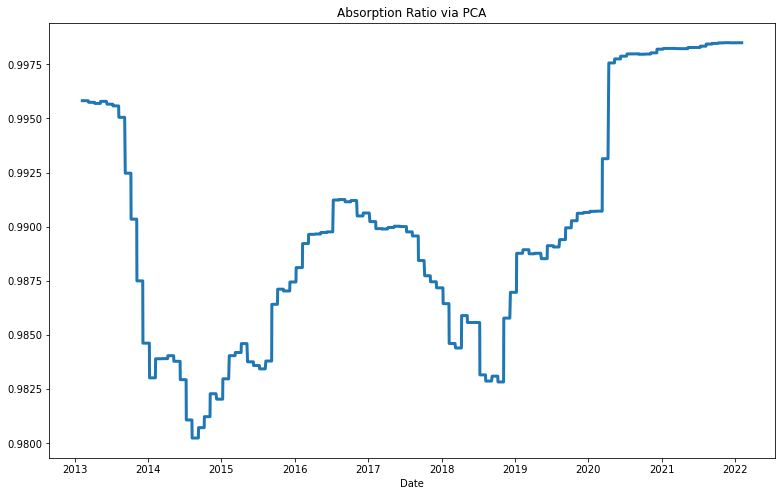

In [116]:
#how much variance do the fix 20% of principal components explain?
sns.lineplot(data=ts_absorb_ratio, linewidth=3)
plt.title('Absorption Ratio via PCA')
#plt.savefig("Absorption_Ratio_SPX.png", dpi=900)

## Deriving a trading strategy from the absorption ratio according to the Kritzman paper
Having computed daily (this means the step size is 1) Absorption Ratio times series, we further follow M. Kritzman to make use of AR to define yet another measure: AR Delta. In particular:
$$ AR\delta = \frac{AR_{15d} - AR_{1y}}{ AR\sigma_{1y}}$$
We use  $AR\delta$ to build simple portfolio trading strategy

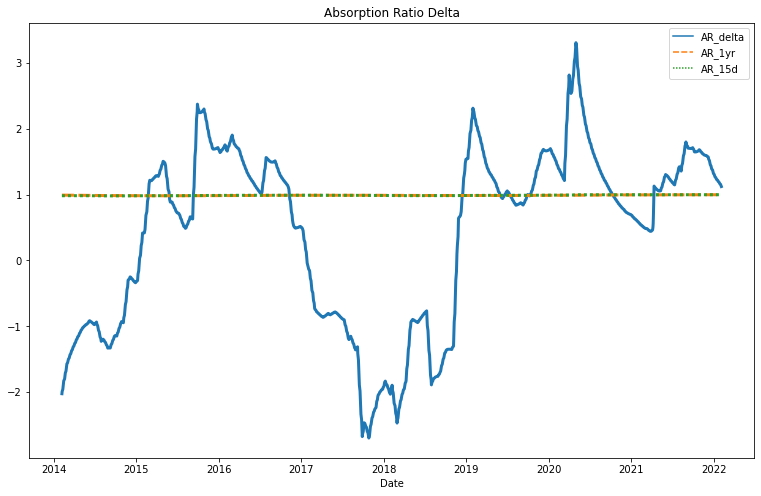

In [117]:
# following Kritzman and computing AR_delta = (15d_AR -1yr_AR) / sigma_AR
ts_ar = ts_absorb_ratio
ar_mean_1yr = ts_ar.rolling(252).mean()
ar_mean_15d = ts_ar.rolling(15).mean()
ar_sd_1yr = ts_ar.rolling(252).std()
ar_delta = (ar_mean_15d - ar_mean_1yr) / ar_sd_1yr    # standardized shift in absorption ratio

df_plot = pd.DataFrame({'AR_delta': ar_delta.values, 'AR_1yr': ar_mean_1yr.values, 'AR_15d': ar_mean_15d.values}, 
                       index=ts_ar.index)
df_plot = df_plot.dropna()
if df_plot.shape[0] > 0:
    sns.lineplot(data=df_plot, linewidth=3)
    plt.title("Absorption Ratio Delta")

#### Part 3 (AR Delta Trading Strategy)

The AR Delta trading strategy forms a portfolio of EQ and FI, following these simple rules:

* __$ -1\sigma < AR < +1\sigma $__	 50 / 50 weights for EQ / FI
* __$ AR > +1\sigma $__	             0 / 100 weights for EQ / FI
* __$ AR < -1\sigma $__	             100 / 0 weights for EQ / FI

Here we compute AR Delta strategy weights using data from the same data set. As expected, the average number of trades per year is very low.

In [118]:
def get_weight(ar_delta):
    '''
    Calculate EQ / FI portfolio weights based on Absorption Ratio delta
    Arguments:
    ar_delta -- Absorption Ratio delta
    
    Return: 
        wgts -- a vector of portfolio weights
    '''
    if ar_delta > 1: return [0.0,1.0]
    if ar_delta < -1: return [1.0, 0.0]
    return [0.5, 0.5]

In [124]:
ar_delta_data = ar_delta[251:]

rebal_dates = np.zeros(len(ar_delta_data))
wgts = pd.DataFrame(data=np.zeros((len(ar_delta_data.index), 2)), index=ar_delta_data.index, columns=('EQ', 'FI'))

prtf_wgts = get_weight(ar_delta_data.values[0])
wgts.iloc[0, :] = prtf_wgts
for ix in range(1, len(ar_delta_data)):
    prtf_wgts = get_weight(ar_delta_data.values[ix])
    wgts.iloc[ix, :] = prtf_wgts
    if wgts.iloc[ix-1, :][0] != prtf_wgts[0]:
        rebal_dates[ix] = 1

ts_rebal_dates = pd.Series(rebal_dates, index=ar_delta_data.index)
ts_trades_per_year = ts_rebal_dates.groupby([ts_rebal_dates.index.year]).sum()
print('Average number of trades per year %.2f' % ts_trades_per_year.mean())
display(wgts.tail())

Average number of trades per year 2.22


,EQ,FI
Date,,
2022-01-31,0.0,1.0
2022-02-01,0.0,1.0
2022-02-02,0.0,1.0
2022-02-03,0.0,1.0
2022-02-04,0.0,1.0


Now that weights have been determined, run the re-balancing strategy using time series of returns and compute
 - sharpe of the strategy
 - strategy annualized return
 - strategy annualized volatility

Contrast this with 50 / 50 Equity / Fixed Income ETF strategy performance using the same performance metrics. Use VTI as Equity and AGG as Fixed Income assets.

In [127]:
etf_r= pd.read_csv('./pca_hw5_etf_returns.csv',
                     date_parser=lambda dt: pd.to_datetime(dt, format='%Y-%m-%d'),
                     index_col = 0)
etf_prices = pd.read_csv('./millenials_portfolio_etfs.csv',
                         date_parser=lambda dt: pd.to_datetime(dt, format='%Y-%m-%d'),
                         index_col = 0)
etf_returns = etf_prices.pct_change(periods=1)
etf_returns = etf_returns.iloc[1450:, :]
display(etf_r.tail())
display(etf_returns.tail())

,VTI,AGG
Index,,
2017-08-25,0.002399,0.000727
2017-08-28,0.000399,0.000364
2017-08-29,0.000399,0.001452
2017-08-30,0.005261,-0.000181
2017-08-31,0.006819,0.001360


,VTI,SHV,GLD,TLT,AGG
Index,,,,,
2018-02-12,0.013335,0.000000,0.004809,0.004409,0.000095
2018-02-13,0.003161,-0.000181,0.005663,0.004474,0.000000
2018-02-14,0.013998,0.000000,0.017053,-0.011093,0.000000
2018-02-15,0.012215,0.000181,0.001170,0.003399,0.000000
2018-02-16,0.000428,0.000181,-0.003272,0.005421,0.000000


#### Calculate performance of backtested strategy


In [122]:
def backtest_strategy(strat_wgts, asset_returns, periods_per_year = 252):
    '''
    Calculate portfolio returns and return portfolio strategy performance
    Arguments:
    
    strat_wgts -- pandas.DataFrame of weights of the assets
    asset_returns -- pandas.DataFrame of asset returns
    periods_per_year -- number of return observations per year
    
    Return: 
        (ann_ret, ann_vol, sharpe) -- a tuple of (annualized return, annualized volatility, sharpe ratio)
    '''
    
    together = pd.merge(strat_wgts, asset_returns, left_index=True, right_index=True)
    together["Returns"] = together["EQ"]*together["VTI"]+together["FI"]*together["AGG"]
    annualized_return = np.prod(together.Returns.values + 1)**(periods_per_year/len(together.Returns))-1
    annualized_volatility = together.Returns.std() * np.sqrt(periods_per_year)
    return annualized_return, annualized_volatility, annualized_return/annualized_volatility

In [123]:
ann_ret, ann_vol, sharpe = backtest_strategy(wgts, etf_r)
print('Absorption Ratio strategy:', ann_ret, ann_vol, sharpe)
eq_wgts = wgts.copy()
eq_wgts.iloc[:, ] = 0.5
ann_ret_eq_wgt, ann_vol_eq_wgt, sharpe_eq_wgt = backtest_strategy(eq_wgts, etf_r)
print('Equally weighted:', ann_ret_eq_wgt, ann_vol_eq_wgt, sharpe_eq_wgt)

Absorption Ratio strategy: 0.06170501702557174 0.06439307890741693 0.9582554223613065
Equally weighted: 0.07611697416460972 0.061249986094747404 1.2427263909393322
